In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.utils.data
import torch.optim as optim
import torch.nn.functional as F
import wfdb
import random
import time
import cpuinfo
import subprocess
import psutil

In [2]:
cpu_info = cpuinfo.get_cpu_info()
print(f"Brand: {cpu_info['brand_raw']}")
print(f"Architecture: {cpu_info['arch']}")
print(f"Bits: {cpu_info['bits']}")
print(f"Count: {cpu_info['count']}\n")

if torch.cuda.is_available():
    print(f"Total GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"Memory Allocated: {torch.cuda.memory_allocated(i) / 1e9} GB")
        print(f"Memory Cached: {torch.cuda.memory_reserved(i) / 1e9} GB\n")
else:
    print("CUDA is not available. Listing CPUs instead.\n")
    print(cpuinfo.get_cpu_info()['brand_raw'])
    
vm = psutil.virtual_memory()
print(f"Total memory: {vm.total / 1e9} GB")
print(f"Available memory: {vm.available / 1e9} GB")
print(f"Used memory: {vm.used / 1e9} GB")

Brand: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Architecture: X86_64
Bits: 64
Count: 12

Total GPUs: 1
GPU 0: NVIDIA GeForce RTX 2060
Memory Allocated: 0.0 GB
Memory Cached: 0.0 GB

Total memory: 17.049710592 GB
Available memory: 5.814378496 GB
Used memory: 11.235332096 GB


In [3]:
# Seed Function
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

In [4]:
# ECG Dataset from CSV
class ECGCSVDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        self.data = pd.read_csv(path, header=None)
        
    def __getitem__(self, idx):
        x = self.data.loc[idx, :186].values
        return torch.from_numpy(x).float()
    
    def __len__(self):
        return len(self.data)

# ECG Dataset from MIT-BIH
class ECGStressDataset(torch.utils.data.Dataset):
    def __init__(self, records, directory, length=187):
        self.records = records
        self.directory = directory
        self.length = length

    def __getitem__(self, idx):
        record = wfdb.rdrecord(os.path.join(self.directory, self.records[idx]), sampto=self.length)
        ecg_signal = record.p_signal[:self.length].flatten()
        ecg_signal = (ecg_signal - np.mean(ecg_signal)) / np.std(ecg_signal)
        return torch.from_numpy(ecg_signal).float()

    def __len__(self):
        return len(self.records)

In [5]:
# Paths and Device Configuration
root_path = "D:\\COLLEGE\\THESIS\\DATASETS\\ecg-id-database-1.0.0\\ecg-id-database-1.0.0\\Person_02"
input_path = root_path + "\\input"  # Adjust if the input folder structure is different
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
print(device)

cuda:0


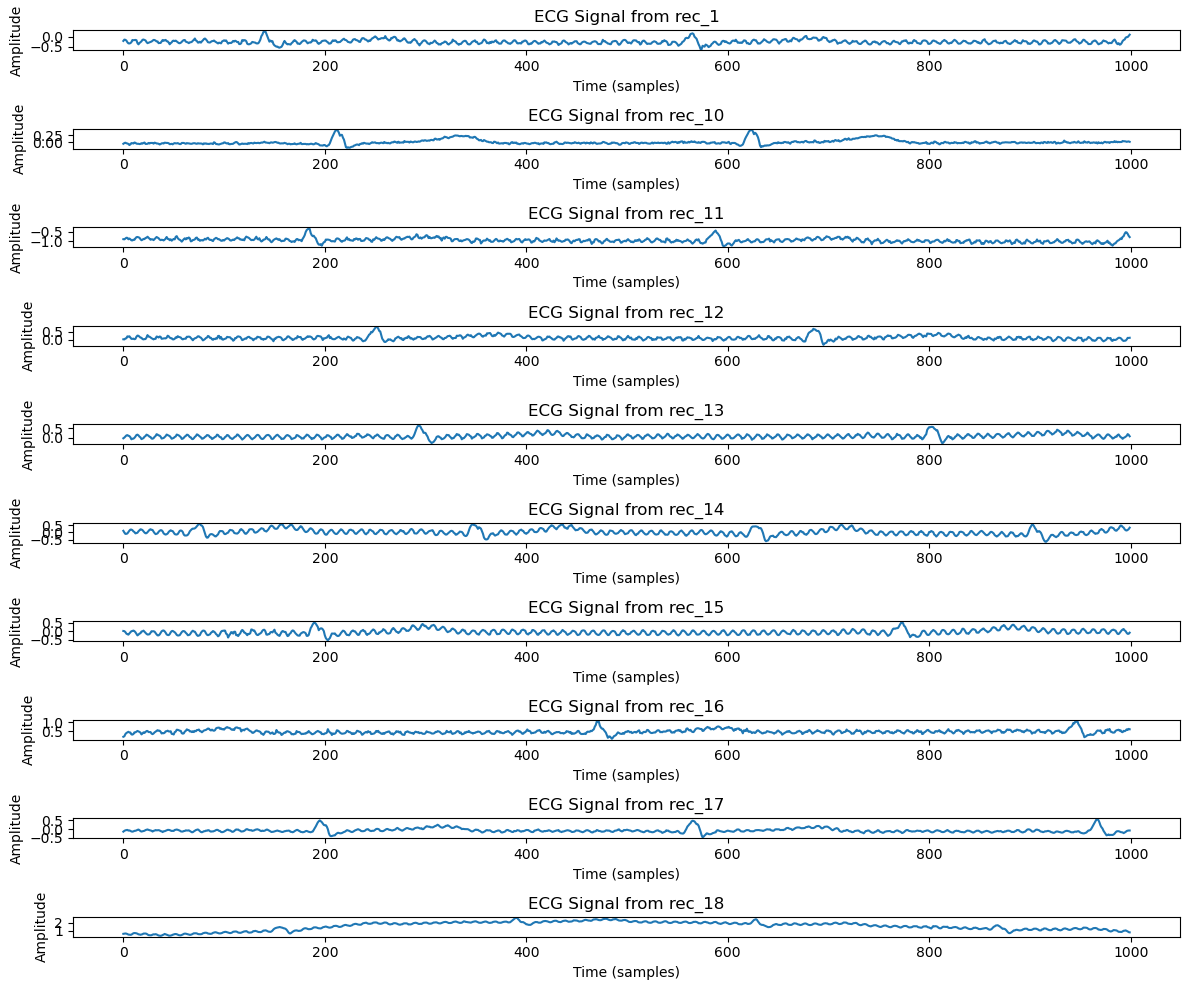

Heart Rate Variability (HRV) Measures:
Record		Mean RR (ms)	Std RR (ms)
rec_1	423.26		192.03
rec_10	400.32		161.33
rec_11	409.68		189.19
rec_12	407.68		177.87
rec_13	461.16		227.74
rec_14	261.26		96.99
rec_15	580.32		263.12
rec_16	430.42		202.33
rec_17	411.79		178.57
rec_18	252.32		76.39
rec_19	336.32		137.07
rec_2	359.26		129.75
rec_20	452.84		228.31
rec_21	464.95		217.50
rec_22	349.37		127.14
rec_3	318.95		123.90
rec_4	378.00		144.81
rec_5	406.53		171.16
rec_6	415.68		179.88
rec_7	391.37		154.82
rec_8	442.74		204.57
rec_9	373.37		133.39


In [6]:
# List all the record names in the Person_02 folder
record_names = [f.split('.')[0] for f in os.listdir(root_path) if f.endswith('.hea')]

# Function to plot ECG signals
def plot_ecg_signals(record_names, data_path, num_signals=10, signal_length=1000):
    plt.figure(figsize=(12, 10))
    for i, record_name in enumerate(record_names[:num_signals]):
        record = wfdb.rdrecord(os.path.join(data_path, record_name))
        ecg_signal = record.p_signal[:,0]  # Assuming the ECG is in the first channel
        plt.subplot(num_signals, 1, i + 1)
        plt.plot(ecg_signal[:signal_length])
        plt.title(f'ECG Signal from {record_name}')
        plt.xlabel('Time (samples)')
        plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

# Plot the first few ECG signals from the Person_02 folder
plot_ecg_signals(record_names, root_path)

# Analyze the heart rate variability (HRV) for drowsiness detection
def analyze_hrv(record_names, data_path):
    hrv_measures = []
    for record_name in record_names:
        record = wfdb.rdrecord(os.path.join(data_path, record_name))
        annotation = wfdb.rdann(os.path.join(data_path, record_name), 'atr')
        rr_intervals = np.diff(annotation.sample) / record.fs * 1000  # Convert to milliseconds
        mean_rr = np.mean(rr_intervals)
        std_rr = np.std(rr_intervals)
        hrv_measures.append((record_name, mean_rr, std_rr))
    return hrv_measures

# Get HRV measures for the records in the Person_02 folder
hrv_measures = analyze_hrv(record_names, root_path)
print("Heart Rate Variability (HRV) Measures:")
print("Record\t\tMean RR (ms)\tStd RR (ms)")
for measure in hrv_measures:
    print(f"{measure[0]}\t{measure[1]:.2f}\t\t{measure[2]:.2f}")


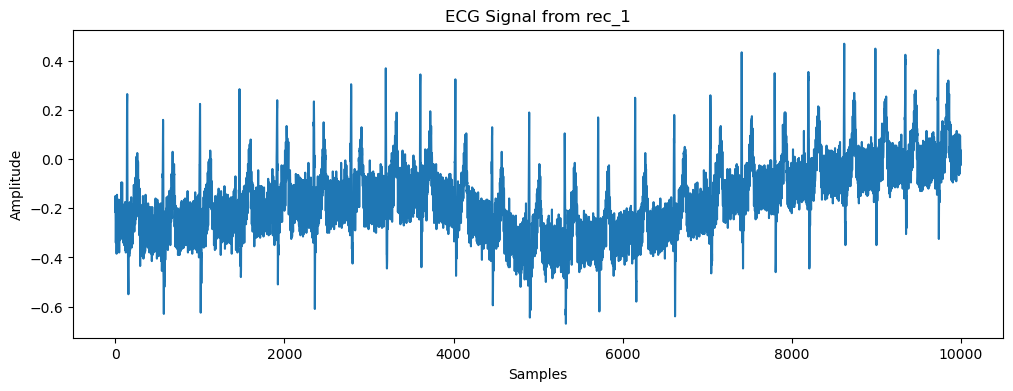

Basic Statistics for rec_1:
Mean: -0.17
Standard Deviation: 0.15
Min: -0.67
Max: 0.47
--------------------------------------------------


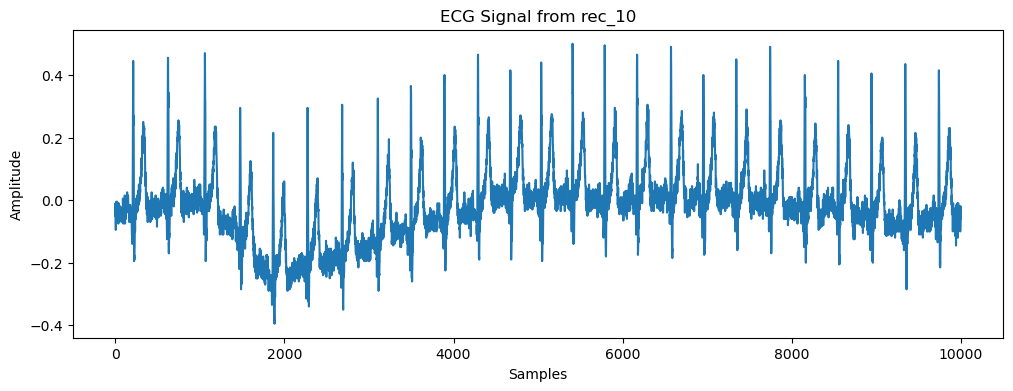

Basic Statistics for rec_10:
Mean: -0.02
Standard Deviation: 0.12
Min: -0.40
Max: 0.50
--------------------------------------------------


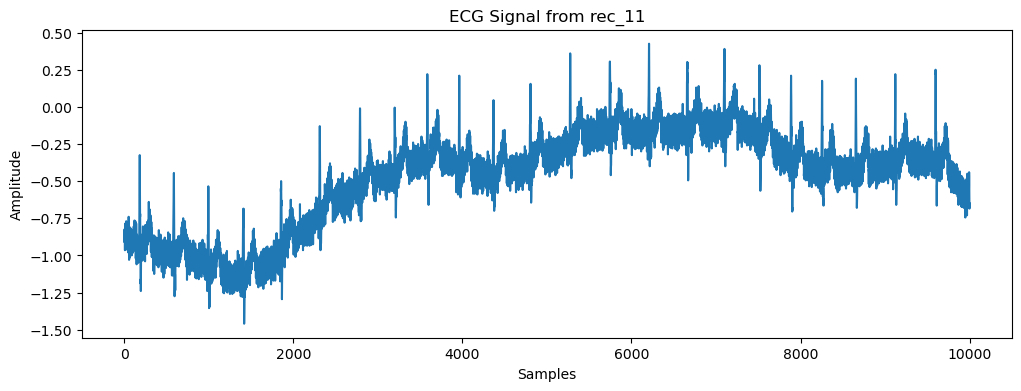

Basic Statistics for rec_11:
Mean: -0.47
Standard Deviation: 0.32
Min: -1.46
Max: 0.42
--------------------------------------------------


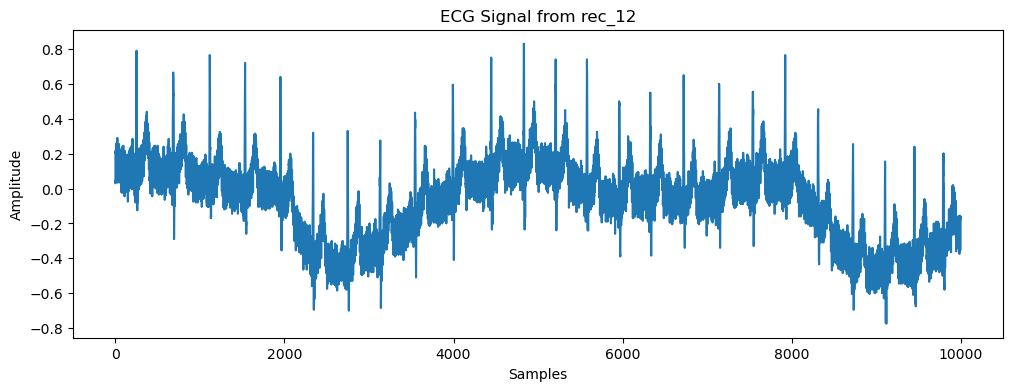

Basic Statistics for rec_12:
Mean: -0.07
Standard Deviation: 0.23
Min: -0.78
Max: 0.83
--------------------------------------------------


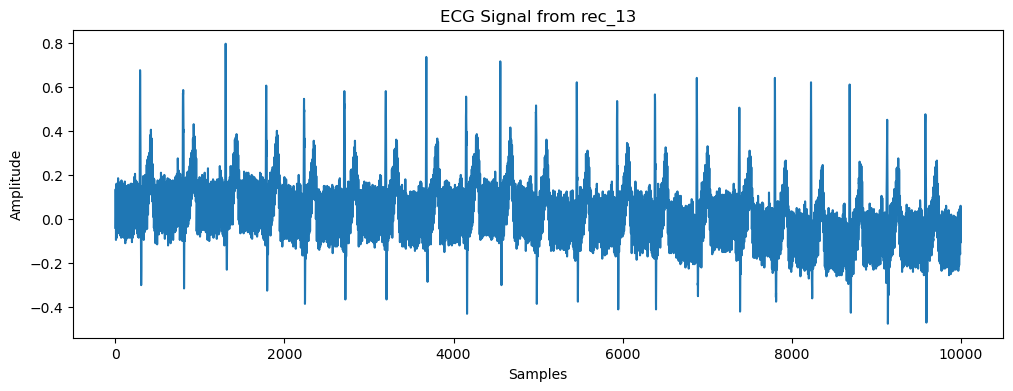

Basic Statistics for rec_13:
Mean: 0.02
Standard Deviation: 0.14
Min: -0.47
Max: 0.80
--------------------------------------------------


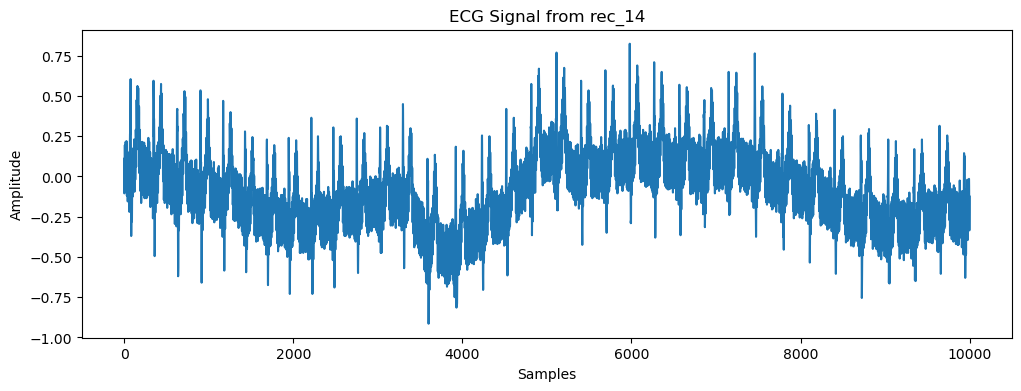

Basic Statistics for rec_14:
Mean: -0.08
Standard Deviation: 0.24
Min: -0.92
Max: 0.82
--------------------------------------------------


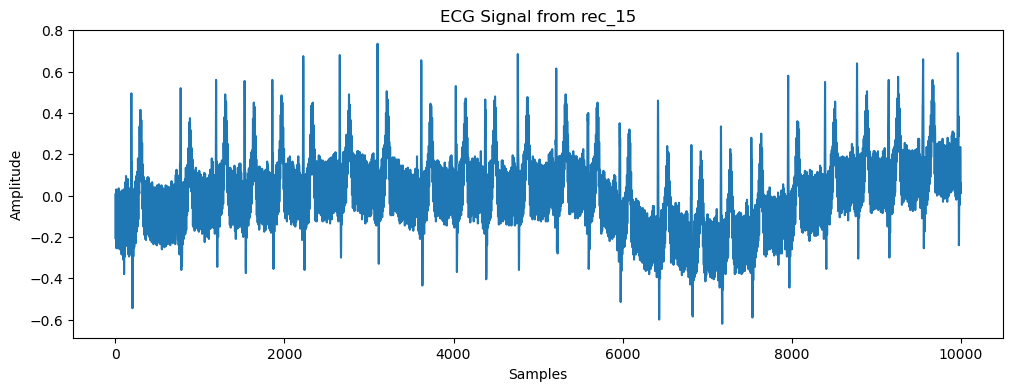

Basic Statistics for rec_15:
Mean: 0.01
Standard Deviation: 0.18
Min: -0.62
Max: 0.73
--------------------------------------------------


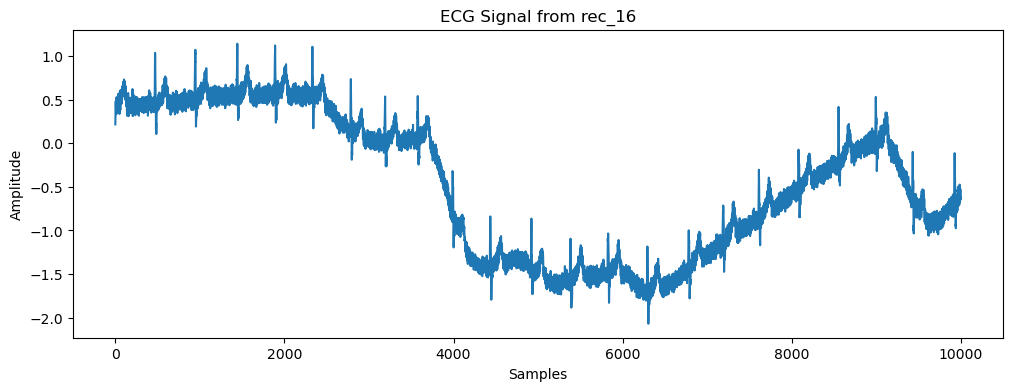

Basic Statistics for rec_16:
Mean: -0.46
Standard Deviation: 0.80
Min: -2.07
Max: 1.14
--------------------------------------------------


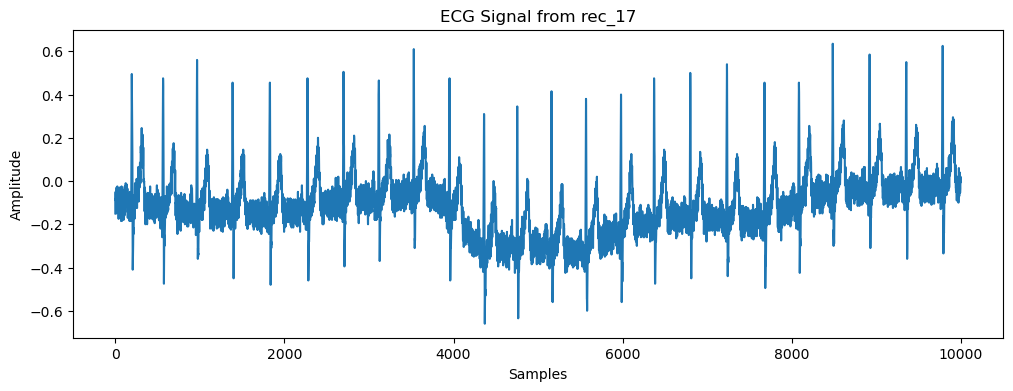

Basic Statistics for rec_17:
Mean: -0.11
Standard Deviation: 0.14
Min: -0.66
Max: 0.64
--------------------------------------------------


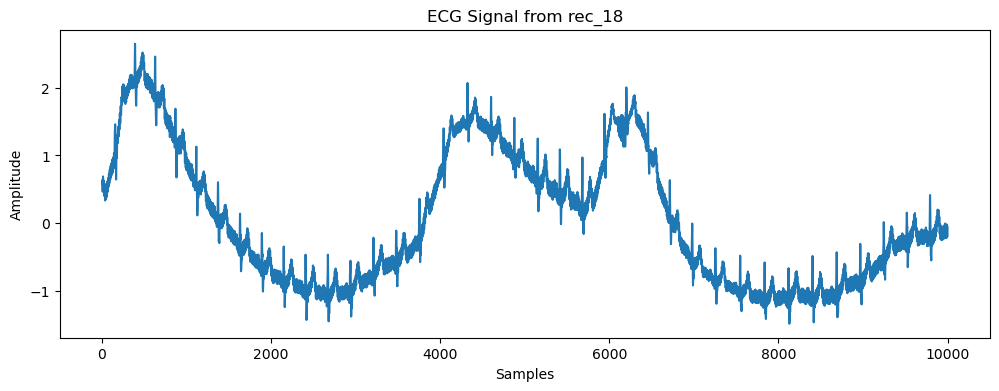

Basic Statistics for rec_18:
Mean: 0.06
Standard Deviation: 0.98
Min: -1.49
Max: 2.65
--------------------------------------------------
Basic Statistics for All Signals Combined:
Mean: -0.06
Standard Deviation: 0.36
Min: -2.07
Max: 2.65


In [7]:
# List all the record names in the Person_02 folder
record_names = [f.split('.')[0] for f in os.listdir(root_path) if f.endswith('.hea')]

# Function to plot ECG signals and print basic statistics
def plot_ecg_signals_and_stats(record_names, data_path, num_signals=10):
    for i, record_name in enumerate(record_names[:num_signals]):
        record = wfdb.rdrecord(os.path.join(data_path, record_name))
        ecg_signal = record.p_signal[:,0]  # Assuming the ECG is in the first channel

        # Plot the ECG signal
        plt.figure(figsize=(12, 4))
        plt.plot(ecg_signal)
        plt.title(f'ECG Signal from {record_name}')
        plt.xlabel('Samples')
        plt.ylabel('Amplitude')
        plt.show()

        # Print basic statistics
        print(f"Basic Statistics for {record_name}:")
        print(f"Mean: {np.mean(ecg_signal):.2f}")
        print(f"Standard Deviation: {np.std(ecg_signal):.2f}")
        print(f"Min: {np.min(ecg_signal):.2f}")
        print(f"Max: {np.max(ecg_signal):.2f}")
        print("-" * 50)

# Plot ECG signals and print basic statistics for the first 5 records
plot_ecg_signals_and_stats(record_names, root_path)

# Calculate and print basic statistics for all signals combined
all_signals = np.concatenate([wfdb.rdrecord(os.path.join(root_path, rn)).p_signal[:,0] for rn in record_names])
print("Basic Statistics for All Signals Combined:")
print(f"Mean: {np.mean(all_signals):.2f}")
print(f"Standard Deviation: {np.std(all_signals):.2f}")
print(f"Min: {np.min(all_signals):.2f}")
print(f"Max: {np.max(all_signals):.2f}")


In [8]:
class opt:
    batch_size = 128
    workers = 0
    lr = 0.001
    normal_train_path = input_path + "\\normal_train.csv"
    normal_valid_path = input_path + "\\normal_valid.csv"
    patient_valid_path = input_path + "\\patient_valid.csv"

In [9]:
# KL Autoencoder Definition
class Reg1DCNNAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, 5, stride=1, padding=2), # Output: 187 x 16
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),                          # Output: 93 x 16
            
            nn.Conv1d(16, 32, 5, stride=1, padding=2),# Output: 93 x 32
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),                          # Output: 46 x 32
            
            nn.Conv1d(32, 64, 5, stride=1, padding=2),# Output: 46 x 64
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),                          # Output: 23 x 64
            
            nn.Conv1d(64, 128, 5, stride=1, padding=2),# Output: 23 x 128
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),                          # Output: 11 x 128
        )
        
        # The encoder will produce the mean and log variance for each latent vector component
        self.fc_mu = nn.Linear(11 * 128, 128)
        self.fc_logvar = nn.Linear(11 * 128, 128)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Upsample(size=22, mode='nearest'),  # Upsample to 22 x 128
            nn.ConvTranspose1d(128, 64, 5, stride=2, padding=2, output_padding=1), # Output: 44 x 64
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(64, 32, 5, stride=2, padding=2, output_padding=1),  # Output: 88 x 32
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(32, 16, 3, stride=2, padding=1, output_padding=1),  # Output: 176 x 16
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(16, 1, 12, stride=1, padding=0),   # Output: 187 x 1
            nn.Sigmoid()
        )
        
    def reparameterize(self, mu, logvar):
        """Sample from the distribution having latent parameters mu and logvar."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, inp):
        inp = inp.view(-1, 1, 187)
        
        # Encoder
        x = self.encoder(inp)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        
        # Reparameterization trick
        z = self.reparameterize(mu, logvar)
        
        # Decoder
        z = z.view(z.size(0), 128, 1).expand(-1, -1, 11)
        out = self.decoder(z)
        
        return out.view(-1, 187), mu, logvar

In [10]:
from torchsummary import summary

model = Reg1DCNNAutoencoder().to(device)
summary(model, input_size=(1, 187))  # Adjust input_size based on model's input


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 187]              96
              ReLU-2              [-1, 16, 187]               0
         MaxPool1d-3               [-1, 16, 93]               0
            Conv1d-4               [-1, 32, 93]           2,592
              ReLU-5               [-1, 32, 93]               0
         MaxPool1d-6               [-1, 32, 46]               0
            Conv1d-7               [-1, 64, 46]          10,304
              ReLU-8               [-1, 64, 46]               0
         MaxPool1d-9               [-1, 64, 23]               0
           Conv1d-10              [-1, 128, 23]          41,088
             ReLU-11              [-1, 128, 23]               0
        MaxPool1d-12              [-1, 128, 11]               0
           Linear-13                  [-1, 128]         180,352
           Linear-14                  [

In [11]:
from torchviz import make_dot

# Create a dummy input tensor appropriate for your model
dummy_input = torch.randn(1, 1, 187, device=device)  # Adjust the shape to match your model's input

# Perform a forward pass (just for visualization purposes)
output = model(dummy_input)

# Create a visualization of the model
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("model_architecture", format="png")  # This will save a PNG image of your model


'model_architecture.png'

In [12]:
# Loss Function Definition
#def loss_function(recon_x, x):
    #MSE = F.mse_loss(recon_x, x, reduction='sum')
    #return MSE

torch.Size([128, 187]) torch.float32


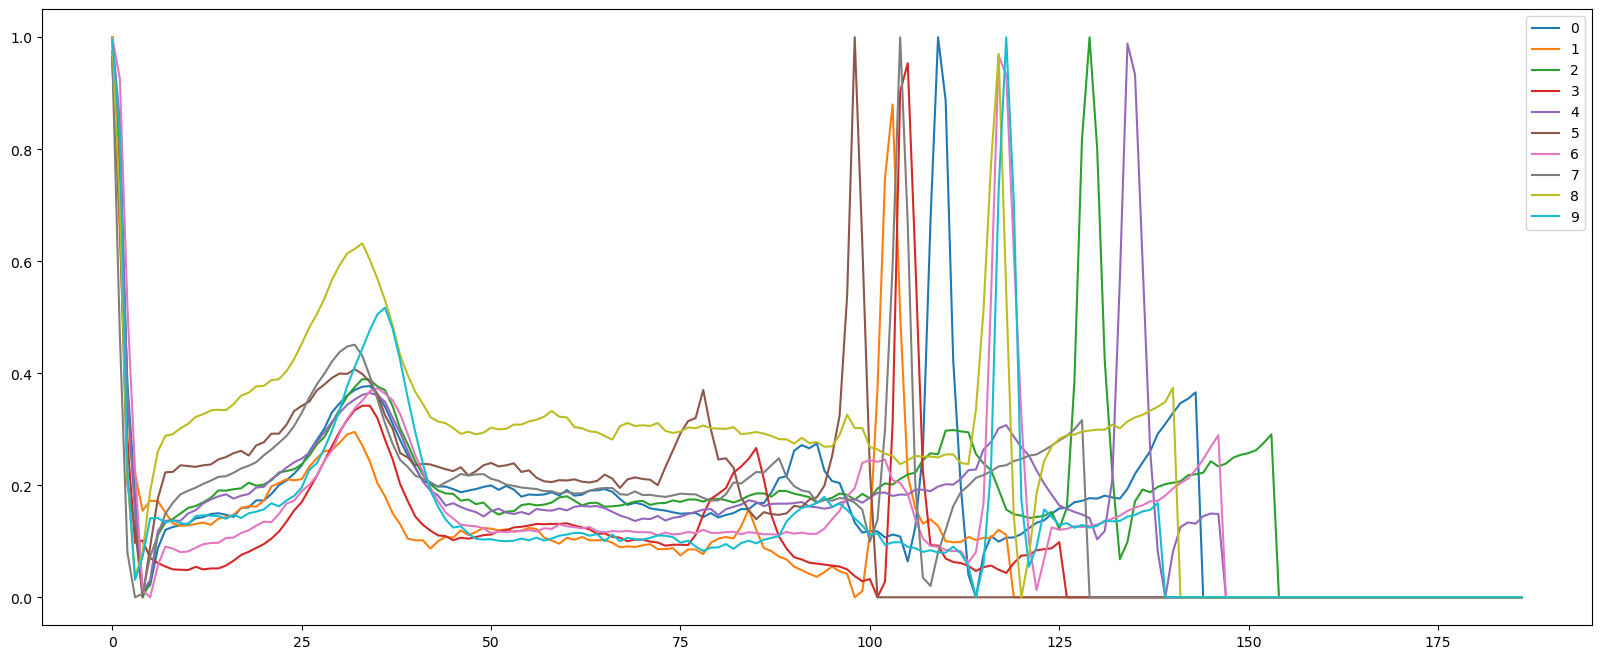

In [13]:
# Load CSV Data for Training
normal_train_dset = ECGCSVDataset(opt.normal_train_path)
trainloader = torch.utils.data.DataLoader(normal_train_dset, batch_size=opt.batch_size, shuffle=True, num_workers=opt.workers)

for x in trainloader:
    print(x.shape,x.dtype)
    x=x.numpy()
    x=pd.DataFrame(x)
    x.iloc[:10,:].T.plot(figsize=(20,8))
    plt.show() #plot to check the data pipeline is working well
    break

In [14]:
# Initialize Model and Optimizer
model=Reg1DCNNAutoencoder().to(device)
optimizer=optim.Adam(model.parameters(),lr=opt.lr)

def loss_function(pred, real, mu, logvar):
    # Reconstruction loss
    mse = F.mse_loss(pred, real, reduction="sum")

    # KL divergence loss
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return mse + kld

In [15]:
total_loss = []
total_mse = []
total_mae = []

model.train()
t1 = time.time()

for epoch in range(100):
    loss_count = 0
    mse_count = 0
    mae_count = 0
    
    for i, signal in enumerate(trainloader):
        signal = signal.to(device).float()
        output, mu, logvar = model(signal)
        
        loss = loss_function(output, signal, mu, logvar)
        loss_count += loss.item()
        
        # MSE and MAE calculations
        mse = F.mse_loss(output, signal, reduction="sum")
        mse_count += mse.item()
        
        mae = F.l1_loss(output, signal, reduction="sum")
        mae_count += mae.item()
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
    epoch_loss = loss_count / len(trainloader)
    epoch_mse = mse_count / len(trainloader.dataset)
    epoch_mae = mae_count / len(trainloader.dataset)
    
    total_loss.append(epoch_loss)
    total_mse.append(epoch_mse)
    total_mae.append(epoch_mae)
    
    if epoch % 10 == 0:
        epoch+=10
        print(f"Epoch: {epoch} Loss: {loss_count:.4f} MSE: {total_mse[-1]:.4f} MAE: {total_mae[-1]:.4f}")
        torch.save(model.state_dict(), f"klconv_epoch_{epoch}.pt")

t2 = time.time()
time_taken = (t2 - t1) / 60
print(f"Total Time Taken: {time_taken:.2f} minutes")

Epoch: 10 Loss: 53828.9619 MSE: 13.3366 MAE: 39.6285
Epoch: 20 Loss: 20346.6054 MSE: 4.9675 MAE: 22.3375
Epoch: 30 Loss: 18328.7582 MSE: 4.4282 MAE: 20.5004
Epoch: 40 Loss: 17741.4203 MSE: 4.2574 MAE: 19.7157
Epoch: 50 Loss: 17466.6710 MSE: 4.1959 MAE: 19.2906
Epoch: 60 Loss: 17381.5920 MSE: 4.1715 MAE: 19.1953
Epoch: 70 Loss: 17237.5603 MSE: 4.1474 MAE: 19.0735
Epoch: 80 Loss: 17206.3445 MSE: 4.1268 MAE: 18.9931
Epoch: 90 Loss: 17287.5147 MSE: 4.1530 MAE: 19.0779
Epoch: 100 Loss: 17228.0371 MSE: 4.1213 MAE: 18.9389
Total Time Taken: 1.03 minutes


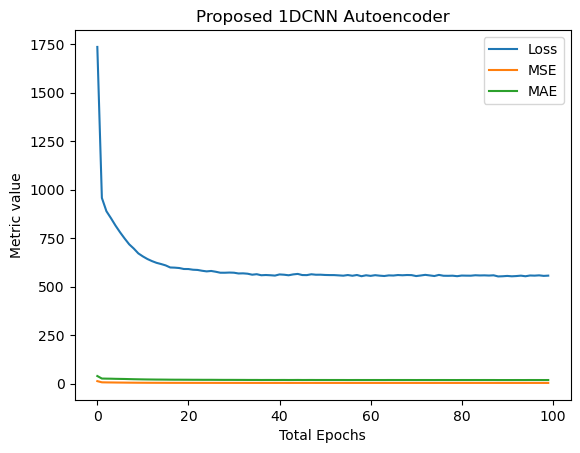

In [16]:
plt.plot(list(range(len(total_loss))), total_loss, label='Loss')
plt.plot(list(range(len(total_mse))), total_mse, label='MSE')
plt.plot(list(range(len(total_mae))), total_mae, label='MAE')
plt.title("Proposed 1DCNN Autoencoder")
plt.xlabel("Total Epochs")
plt.ylabel("Metric value")
plt.legend()
plt.show()

In [17]:
# Save Model
torch.save(model.state_dict(), "proposed_1dcnn.pth")


In [18]:
# Load the Trained Model for Testing
model.load_state_dict(torch.load("proposed_1dcnn.pth"))
model = model.to(device)


In [19]:
# Load MIT-BIH Data for Testing
def load_stress_data(directory):
    records = [f.split('.')[0] for f in os.listdir(directory) if f.endswith('.hea')]
    test_dataset = ECGStressDataset(records, directory)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=opt.workers)
    print(test_dataset.records)
    return test_loader

['rec_1', 'rec_10', 'rec_11', 'rec_12', 'rec_13', 'rec_14', 'rec_15', 'rec_16', 'rec_17', 'rec_18', 'rec_19', 'rec_2', 'rec_20', 'rec_21', 'rec_22', 'rec_3', 'rec_4', 'rec_5', 'rec_6', 'rec_7', 'rec_8', 'rec_9']


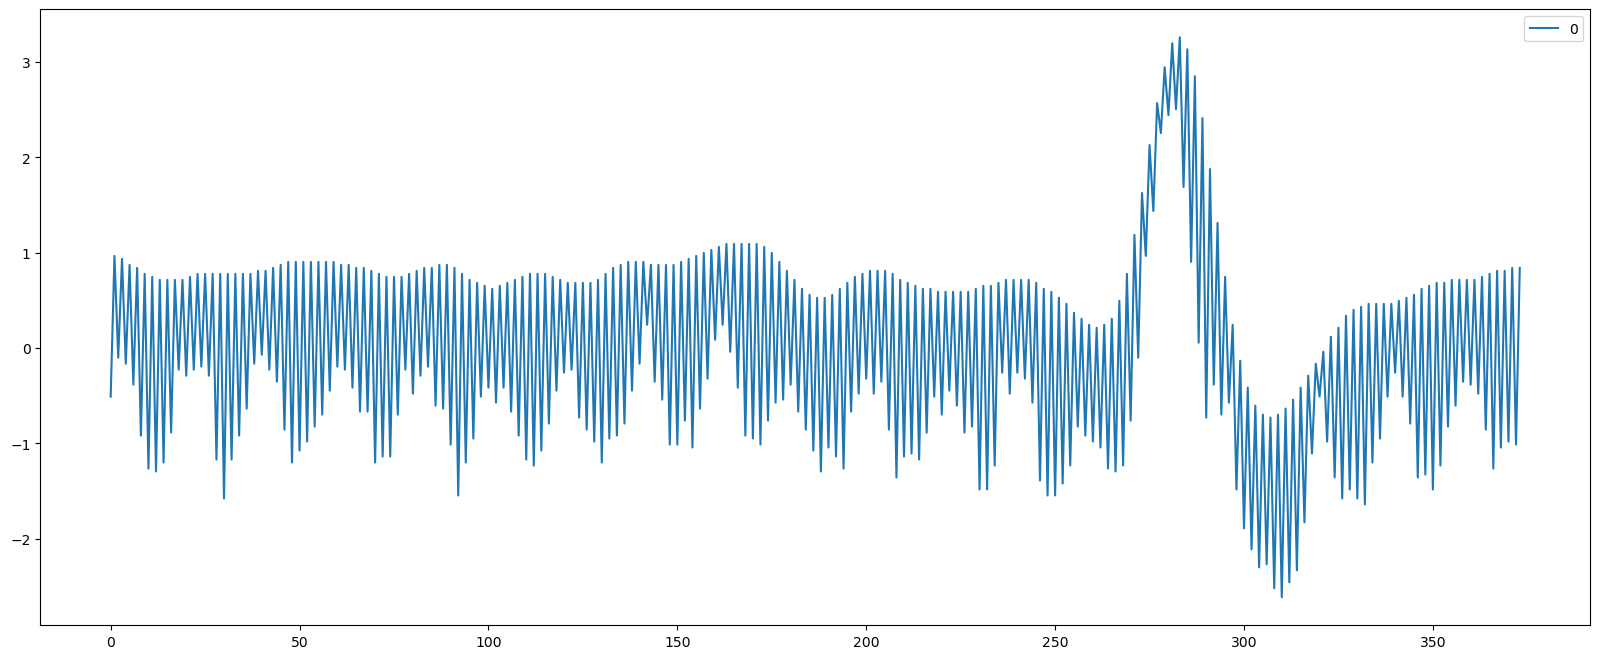

In [20]:
# Load and Test on MIT-BIH Data
stress_test_loader = load_stress_data(root_path)
segment_length = 187  # Adjust as needed


for x in stress_test_loader:
    #print(x.shape,x.dtype)
    x=x.numpy()
    x=pd.DataFrame(x)
    x.iloc[:10,:].T.plot(figsize=(20,8))
    plt.show() #plot to check the data pipeline is working well
    break


In [21]:
# Compute Error Distribution Function
def compute_error_distribution(model, test_loader, device, segment_length):
    model.eval()
    error_list = []

    with torch.no_grad():
        for i, signal in enumerate(test_loader):
            signal = signal.to(device)
            for start_idx in range(0, signal.shape[1] - segment_length + 1, segment_length):
                segment = signal[:, start_idx:start_idx + segment_length]

                # Get the reconstructed output from the model
                reconstructed_output, _, _ = model(segment.unsqueeze(0))

                # Ensure the output shape matches the target shape
                if reconstructed_output.shape != segment.unsqueeze(0).shape:
                    reconstructed_output = reconstructed_output.view(segment.unsqueeze(0).shape)

                # Calculate the reconstruction error
                reconstruction_error = F.mse_loss(reconstructed_output, segment.unsqueeze(0))
                error_list.append(reconstruction_error.item())

    return np.mean(error_list), np.std(error_list)



In [22]:
mean_error, std_error = compute_error_distribution(model, stress_test_loader, device, segment_length)
dynamic_threshold = mean_error + 2 * std_error


In [23]:
# Testing Function
def test_model(model, test_loader, device, threshold, segment_length):
    model.eval()
    drowsiness_detected = False
    drowsiness_segments = []

    with torch.no_grad():
        for i, signal in enumerate(test_loader):
            signal = signal.to(device)
            for start_idx in range(0, signal.shape[1] - segment_length + 1, segment_length):
                segment = signal[:, start_idx:start_idx + segment_length]

                # Get the reconstructed output from the model
                reconstructed_output, _, _ = model(segment.unsqueeze(0))

                # Ensure the output shape matches the target shape
                if reconstructed_output.shape != segment.unsqueeze(0).shape:
                    reconstructed_output = reconstructed_output.view(segment.unsqueeze(0).shape)

                reconstruction_error = F.mse_loss(reconstructed_output, segment.unsqueeze(0))

                if reconstruction_error > threshold:
                    drowsiness_detected = True
                    drowsiness_segments.append((i, start_idx, start_idx + segment_length))
    
    return drowsiness_detected, drowsiness_segments


In [24]:
# Test with Dynamic Threshold
drowsiness_detected, drowsiness_segments = test_model(model, stress_test_loader, device, dynamic_threshold, segment_length)

if drowsiness_detected:
    print("Drowsiness Detected in following segments:")
    print(drowsiness_segments)
    for record_idx, start, end in drowsiness_segments:
        print(f"Record {record_idx}, Segment {start}-{end}")
else:
    print("No Drowsiness Detected")

Drowsiness Detected in following segments:
[(11, 187, 374), (18, 187, 374)]
Record 11, Segment 187-374
Record 18, Segment 187-374


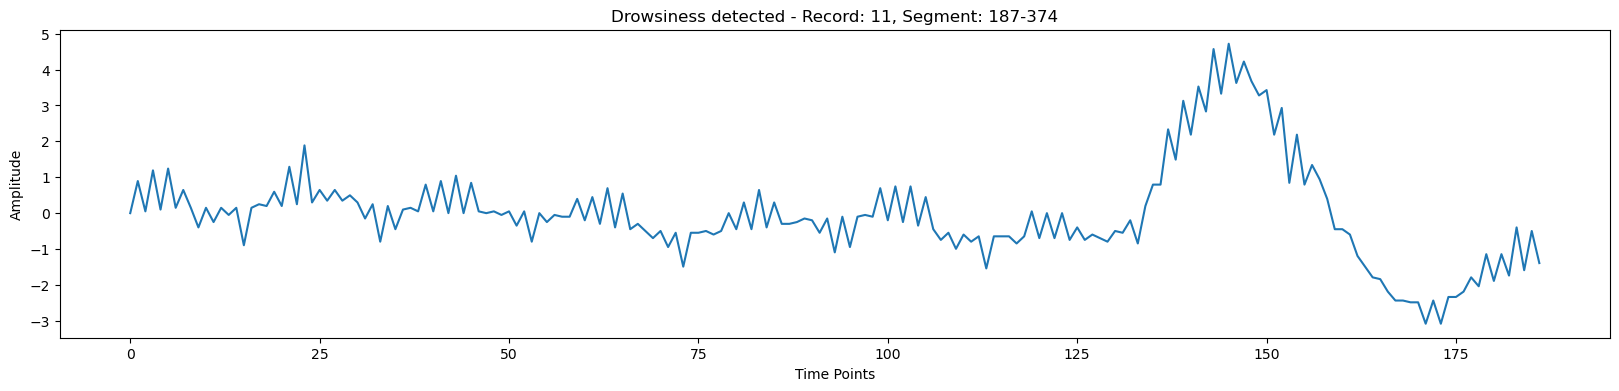

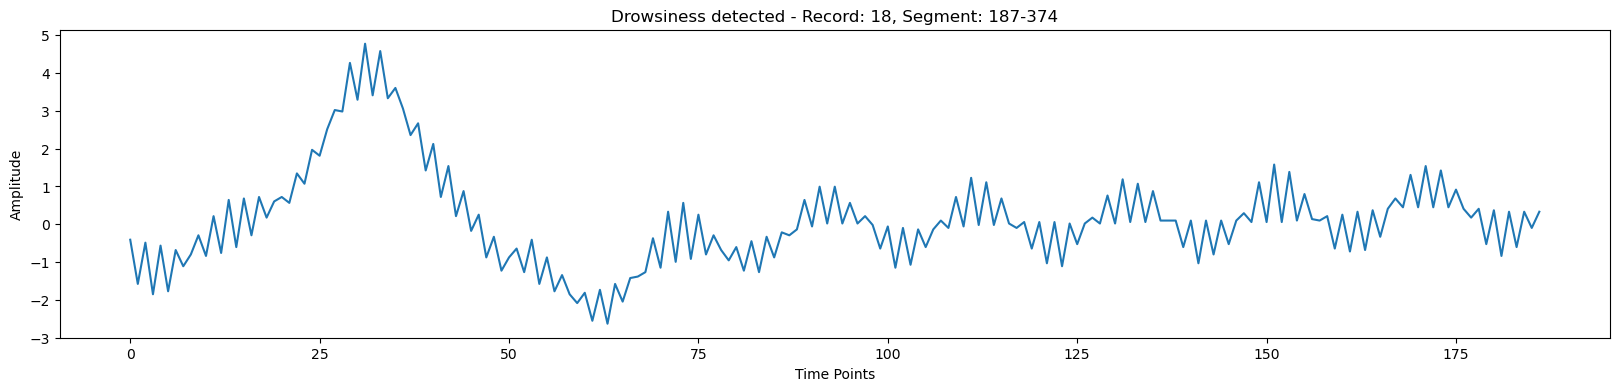

In [25]:
import matplotlib.pyplot as plt
import itertools

def plot_drowsiness_segments(loader, drowsiness_segments, segment_length):
    """
    Plots the ECG segments where drowsiness was detected.
    
    Parameters:
    - loader: DataLoader object containing the ECG dataset.
    - drowsiness_segments: List of tuples with the format (record_index, start_index, end_index)
      indicating the segments where drowsiness was detected.
    - segment_length: Length of each segment in the dataset.
    """
    for record_idx, start, end in drowsiness_segments:
        # Access the specific ECG record where drowsiness was detected.
        # Assuming loader allows sequential access. If shuffle=True, this needs a different approach.
        signal = next(itertools.islice(loader, record_idx, None))

        # Adjust depending on how your DataLoader structures each item.
        # This assumes the DataLoader returns a batch where the first item is the ECG signal.
        signal = signal[0]  # Assuming signal is the first element in the batch
        if isinstance(signal, torch.Tensor):
            signal = signal.cpu().numpy()  # Convert to NumPy array if it's a tensor
        
        # Plot the specific segment
        plt.figure(figsize=(20, 4))
        plt.plot(signal[start:end])
        plt.title(f'Drowsiness detected - Record: {record_idx}, Segment: {start}-{end}')
        plt.xlabel('Time Points')
        plt.ylabel('Amplitude')
        plt.show()

# Now call the function with the correct parameters
plot_drowsiness_segments(stress_test_loader, drowsiness_segments, segment_length)



In [26]:
def calculate_reconstruction_error(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for inputs in data_loader:
            inputs = inputs.to(device)
            reconstructed, _, _ = model(inputs)
            
            # Adjust shapes if necessary before loss calculation
            if reconstructed.shape != inputs.shape:
                # Example adjustment, this is dependent on your specific model and data
                inputs = inputs.view(-1, 187)  # Reshape as necessary
            
            loss = F.mse_loss(reconstructed, inputs, reduction='mean')
            total_loss += loss.item()
            total_samples += inputs.size(0)  # Assuming batch first
    
    average_loss = total_loss / total_samples
    return average_loss



In [27]:
# Example usage
average_reconstruction_error = calculate_reconstruction_error(model, stress_test_loader, device)
print(f"Average Reconstruction Error: {average_reconstruction_error}")


Average Reconstruction Error: 0.5121137310158123
